In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import CoxTimeVaryingFitter
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_seroreversion,
    simulate_infections_survivor,
    simulate_infections_discrete,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide,
    get_constant_foi,
    get_constant_foi_survivor
)

from multipathogen_sero.config import PROJ_ROOT, STAN_DIR, MODEL_FITS_DIR
# # Prepend to PATH (Windows uses ; as separator)
# current_path = os.environ.get('PATH', '')
# new_path = ';'.join(CMDSTAN_PATHS) + ';' + current_path
# os.environ['PATH'] = new_path


2025-08-18 13:44:03.190 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


# Simulation

In [34]:
n_people = 100 #number of individuals n
np.random.seed(42)  # For reproducibility
t_max=100
birth_times = np.random.uniform(0, t_max, size=n_people)  # Random birth times for individuals
n_pathogens=3 #number of pathogens K

pathogen_names = [f'Pathogen {i}' for i in range(1,n_pathogens+1)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]

baseline_hazards = [0.1*k for k in range(1,n_pathogens+1)]  # Example baseline hazards
foi_list = [
    get_constant_foi(a=baseline_hazards[k]) for k in range(n_pathogens)
]
survivor_list = [
    get_constant_foi_survivor(a=baseline_hazards[k]) for k in range(n_pathogens)
]

Text(0.5, 0, 'Time')

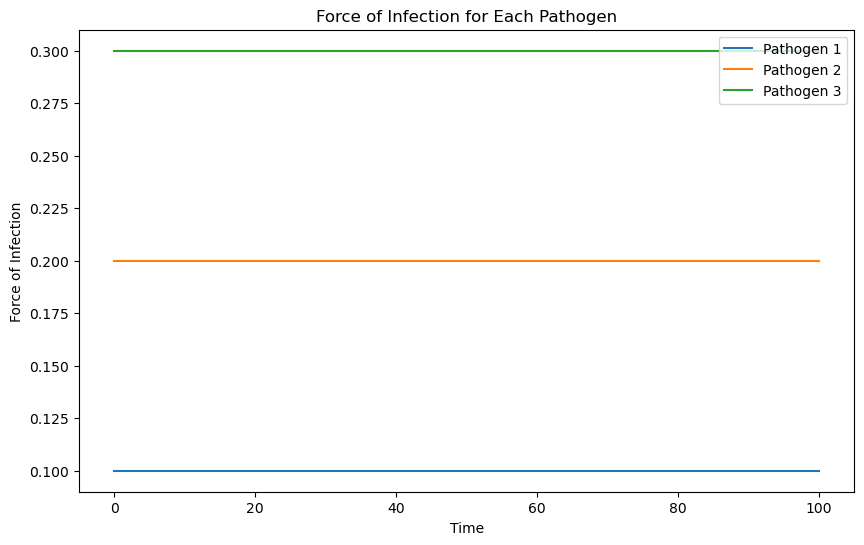

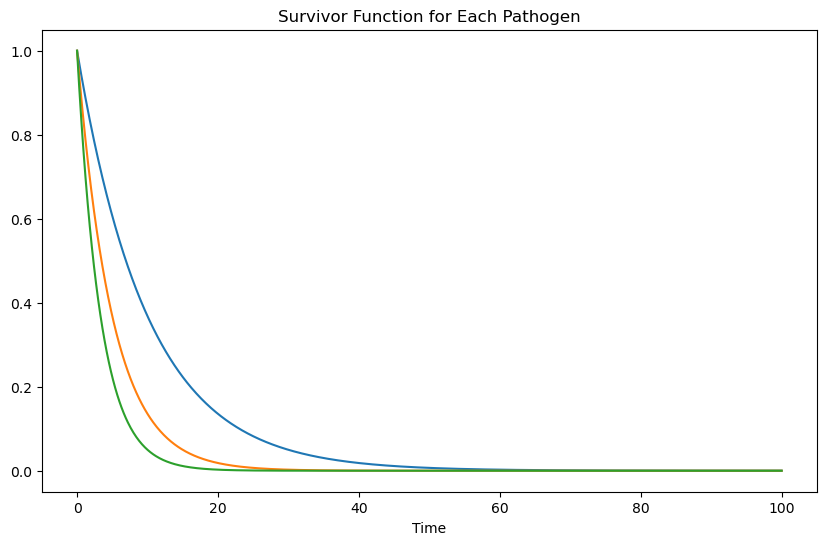

In [77]:
#plot fois
t = np.linspace(0, t_max, 1000)
plt.figure(figsize=(10, 6)) 
for k, foi in enumerate(foi_list):
    plt.plot(t, foi(t), label=pathogen_names[k])
plt.title('Force of Infection for Each Pathogen')
plt.xlabel('Time')
plt.ylabel('Force of Infection')
plt.legend()

#plot survivors
plt.figure(figsize=(10, 6))
for k, survivor in enumerate(survivor_list):
    plt.plot(t, survivor(t), label=pathogen_names[k])
plt.title('Survivor Function for Each Pathogen')
plt.xlabel('Time')

Component 1: [0, 1]
Component 2: [2]


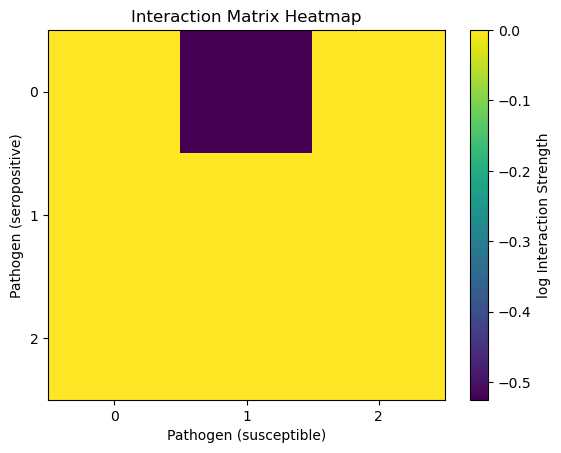

In [3]:
# Interaction matrix

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# spike and slab on each coefficient of the interaction matrix
np.random.seed(42)  # For reproducibility
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
beta_mat = np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
interaction_mat = np.exp(beta_mat)
#plot the interaction matrix as a heatmap
plt.imshow(np.log(interaction_mat), cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (seropositive)')
plt.xlabel('Pathogen (susceptible)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='log Interaction Strength')
plt.title('Interaction Matrix Heatmap')

# Convert interaction_indicator to a sparse matrix
adj_matrix = csr_matrix(interaction_indicator)

# Find weakly connected components (ignoring direction)
n_components, labels = connected_components(csgraph=adj_matrix, directed=True, connection='weak')

# Group node indices by component
components = [np.where(labels == i)[0] for i in range(n_components)]

for i, comp in enumerate(components):
    print(f"Component {i+1}: {comp.tolist()}")

In [35]:
start = time.time()
simulate_infections_df = simulate_infections_seroreversion(
    n_people,
    n_pathogens,
    foi_list,
    interaction_mat=np.ones((n_pathogens, n_pathogens)),  # No interaction for now
    birth_times=birth_times,
    end_times=t_max,
    max_fois=None,
    random_seed=42
)
print(f"simulate_infections_seroreversion took {time.time() - start:.3f} seconds")


simulate_infections_seroreversion took 0.016 seconds


# Bayesian Cox Regression

In [36]:
#########################
k_infector = 2       # Infecting pathogen to analyze
n_people_subsample = min(1000, n_people)  # Subsample size for analysis
#########################


regression_df_for_pathogen_k = simulation_to_regression_df(
    simulate_infections_df,
    k_infector=k_infector,  # Set to None to include all pathogens, or specify a specific pathogen index
    t_max=t_max
)
regression_df_for_pathogen_k_subsampled = regression_df_for_pathogen_k[regression_df_for_pathogen_k["individual"]<=n_people_subsample]

In [37]:
stan_data = {
    "N": n_people_subsample, # Number of individuals
    "P": n_pathogens - 1, # Number of covariates
    "n_rows": len(regression_df_for_pathogen_k_subsampled), # Number of observation rows
    "T_L": regression_df_for_pathogen_k_subsampled["start_time"].values,
    "T_R": regression_df_for_pathogen_k_subsampled["stop_time"].values,
    "event": regression_df_for_pathogen_k_subsampled["event"].values,
    "person_id": regression_df_for_pathogen_k_subsampled["individual"].values,
    "X": regression_df_for_pathogen_k_subsampled.filter(like='serostatus_').values, # get the data for columns starting with serostatus_,
    "beta_prior_setting": 2, # 0 for no prior, 1 for Laplace prior, 2 for spike and slab prior
    "laplace_scale": 1.0,  # scale for Laplace prior when beta_prior_setting == 1
    "slab_scale": 1.0,  # Scale for the slab in spike and slab prior
    "spike_scale": 0.05,  # Scale for the spike in spike and slab prior
    "pi": 0.1 # Inclusion probability for the spike and slab prior
}

In [10]:
model = CmdStanModel(
    stan_file= STAN_DIR / "infection_histories.stan"
)

fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=500,
    iter_warmup=500,
    parallel_chains=4,
    seed=123
)

13:44:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:44:51 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

                        Mean      MCSE    StdDev       MAD           5%  \
lp__            -2444.810000  0.039957  1.217440  1.052650 -2447.220000   
baseline_hazard     0.206400  0.000238  0.008655  0.008731     0.192635   
beta_raw[1]        -0.001407  0.001133  0.040175  0.039986    -0.068089   
beta_raw[2]        -0.004900  0.001173  0.041226  0.040190    -0.069952   
beta[1]            -0.001407  0.001133  0.040175  0.039986    -0.068089   
...                      ...       ...       ...       ...          ...   
log_lik[996]       -3.824930  0.001041

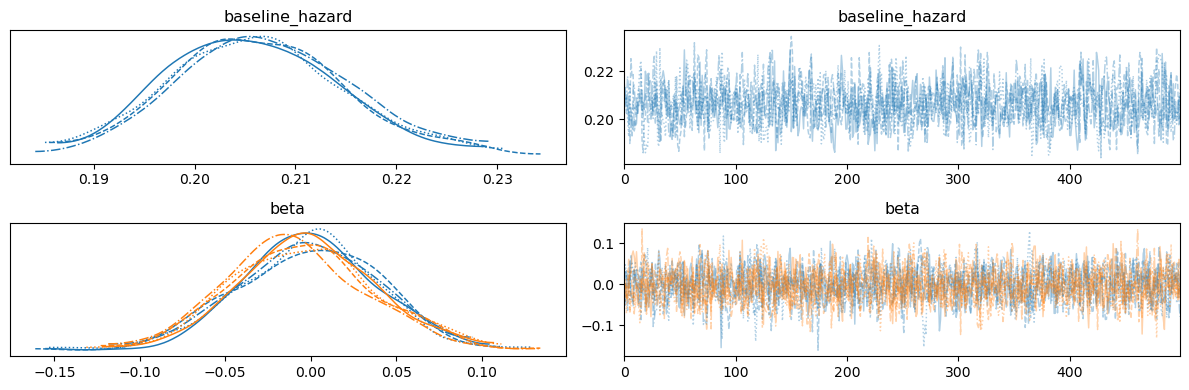

In [11]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazard", "beta"])
plt.tight_layout()
plt.show()

True baseline hazard: 0.2


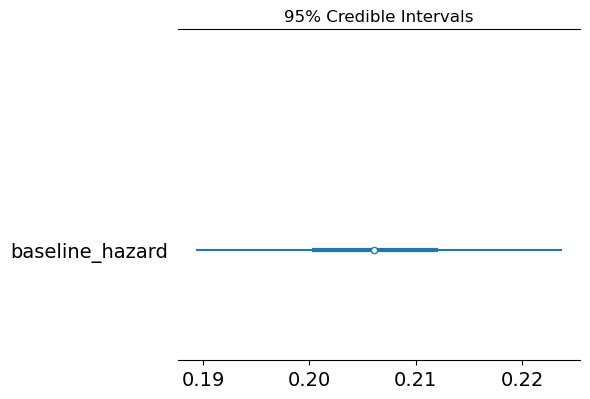

True beta coefficients: [-0.52516981 -0.        ]


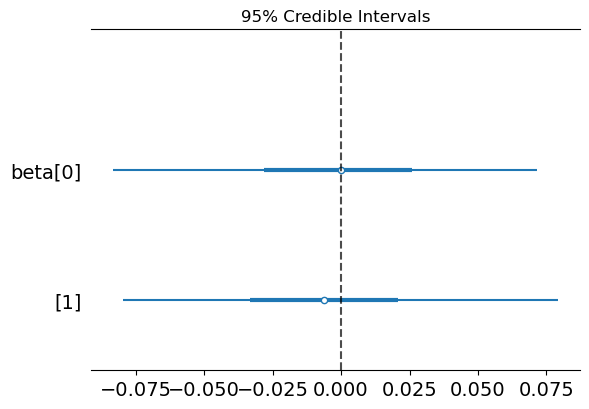

In [12]:
print(f"True baseline hazard: {baseline_hazards[k_infector-1]}")
az.plot_forest(idata, var_names=["baseline_hazard"], 
               hdi_prob=0.95, combined=True)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {np.concatenate([beta_mat[:k_infector-1, k_infector-1],beta_mat[k_infector:, k_infector-1]])}")

ax = az.plot_forest(idata, var_names=["beta"], 
                    hdi_prob=0.95, combined=True)
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

In [14]:
idata = az.from_cmdstanpy(posterior=fit)
# Now you can calculate WAIC and LOO
waic = az.waic(idata)
loo = az.loo(idata)

print(waic)
print(loo)

Computed from 2000 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2448.96    30.87
p_waic        1.71        -
Computed from 2000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2448.96    30.87
p_loo        1.71        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



# serological data

In [38]:
survey_every = 1.0
survey_times = {
    i+1: np.insert(
        survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1),
        0, birth_times[i]
    )
    for i in range(n_people)
}

def get_survey_bounds(row):
    times = survey_times[row["individual"]]
    i = np.searchsorted(times, row["time"], side="left")
    if i == len(times):
        raise NotImplementedError(f"No next survey time ≥ {row['time']} for individual {row['individual']}")
    if i == 0:
        raise NotImplementedError(f"No last survey time < {row['time']} for individual {row['individual']}")
    next_time = times[i]
    last_time = times[i - 1]
    return pd.Series({"last_survey_time": last_time, "next_survey_time": next_time})

# infections
infection_intervals = simulate_infections_df.query("event == 'seroconversion'").copy()
infection_intervals["pathogen"] = infection_intervals["pathogen"].astype(int)
infection_intervals[["last_survey_time", "next_survey_time"]] = infection_intervals.apply(get_survey_bounds, axis=1)
last_survey_times = infection_intervals["last_survey_time"].values
next_survey_times = infection_intervals["next_survey_time"].values
infection_person_ids = infection_intervals["individual"].values
infection_pathogen_ids = infection_intervals["pathogen"].values

# lookup
gets_infected = np.zeros((n_people, n_pathogens), dtype=bool)
lookup_indices = np.zeros((n_people, n_pathogens), dtype=int)
for counter, row in enumerate(infection_intervals.itertuples()):
    gets_infected[row.individual - 1, row.pathogen - 1] = True
    lookup_indices[row.individual - 1, row.pathogen - 1] = counter+1 #1-indexed
num_infections = gets_infected.sum()

# noninfections
num_noninfections = n_people * n_pathogens - num_infections
indices = np.argwhere(gets_infected == 0)
lookup_indices[gets_infected == 0] = np.arange(1, num_noninfections + 1) #1-indexed
noninfection_person_ids = indices[:, 0] + 1  # Convert to 1-based indexing
noninfection_pathogen_ids = indices[:, 1] + 1  # Convert to 1-based indexing
censoring_times = np.array([survey_times[i][-1] for i in noninfection_person_ids])


In [39]:
"""
data {
    int<lower=1> N;                         // Number of individuals
    array[N] real birth_times;               // Birth time for each individual
    int<lower=1> K;                         // Number of pathogens
    array[N,K] int<lower=0, upper=1> gets_infected; // 0 = always negative, 1 = seroconverter
    int<lower=0> num_infections; // Number of infection times (seroconversions)
    int<lower=0> num_noninfections; // Number of uninfected individuals (seronegative)
    array[N,K] int<lower=1, upper=N*K> lookup_indices; // Index to look up individual, pathogen infection times in their respective (1-indexed) arrays
    array[num_infections] real lower_bound_times; // Lower bound of seroconversion time
    array[num_infections] real upper_bound_times; // Upper bound of seroconversion time
    array[num_infections] int<lower=1, upper=N> infection_person_ids; // Individual ID for each seroconversion (should be 1-indexed)
    array[num_infections] int<lower=1, upper=K> infection_pathogen_ids; // Pathogen ID for each seroconversion (should be 1-indexed)
    array[num_noninfections] real censoring_times; // Lower bound of seroconversion time
    array[num_noninfections] int<lower=1, upper=N> noninfection_person_ids; // Individual ID for each seronegative individual (should be 1-indexed)
    array[num_noninfections] int<lower=1, upper=K> noninfection_pathogen_ids; // Pathogen ID for each seronegative individual (should be 1-indexed)
    real <lower=0> time_to_immunity; // timescale for immunity to kick in
                                     // not scientific, just to make the likelihood continuous wrt latent infection times 
    real <lower=0> beta_scale; // scale for Laplace prior on log hazard ratios
}
"""
# TODO: write tests
stan_data = {
    "N": n_people,
    "birth_times": birth_times,
    "K": n_pathogens,
    "gets_infected": gets_infected,
    "num_infections": num_infections,
    "num_noninfections": num_noninfections,
    "lookup_indices": lookup_indices,
    "lower_bound_times": last_survey_times,
    "upper_bound_times": next_survey_times,
    "infection_person_ids": infection_person_ids,
    "infection_pathogen_ids": infection_pathogen_ids,
    "censoring_times": censoring_times,
    "noninfection_person_ids": noninfection_person_ids,
    "noninfection_pathogen_ids": noninfection_pathogen_ids,
    "time_to_immunity": 0.05,  # timescale for immunity to kick in
    "beta_scale": 1.0,  # scale for Laplace prior on log hazard ratios
}

print(birth_times[0])
print(gets_infected[0])
print(lookup_indices[0])
print(last_survey_times[lookup_indices[0][gets_infected[0]]-1])
print(next_survey_times[lookup_indices[0][gets_infected[0]]-1])
print(infection_person_ids[lookup_indices[0][gets_infected[0]]-1])
print(infection_pathogen_ids[lookup_indices[0][gets_infected[0]]-1])
print(censoring_times[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_person_ids[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_pathogen_ids[lookup_indices[0][~gets_infected[0]]-1])

37.454011884736246
[ True  True  True]
[3 1 2]
[46.         37.45401188 37.45401188]
[47. 38. 38.]
[1 1 1]
[1 2 3]
[]
[]
[]


In [50]:
model = CmdStanModel(
    stan_file= STAN_DIR / "multiplex_serology_frailty.stan"
)

16:16:46 - cmdstanpy - INFO - compiling stan file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology_frailty.stan to exe file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology_frailty
16:17:09 - cmdstanpy - INFO - compiled model executable: /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology_frailty


In [51]:
chains = 4
iter_sampling = 50
iter_warmup = 50
parallel_chains = 4
seed = 123
max_treedepth = 15
fit = model.sample(
    data=stan_data,
    chains=chains,
    iter_sampling=iter_sampling,
    iter_warmup=iter_warmup,
    parallel_chains=parallel_chains,
    seed=seed,
    max_treedepth=max_treedepth,
    show_progress=True,
    show_console=True
)

16:17:09 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [2] start processing
16:17:09 - cmdstanpy - INFO - Chain [3] start processing
16:17:09 - cmdstanpy - INFO - Chain [4] start processing


Chain [3] method = sample (Default)Chain [2] method = sample (Default)
Chain [2] sample
Chain [2] num_samples = 50
Chain [2] num_warmup = 50
Chain [2] save_warmup = false (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = true (Default)
Chain [2] gamma = 0.05 (Default)
Chain [2] delta = 0.8 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [2] save_metric = false (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [2] engine = nuts (Default)
Chain [2] nuts
Chain [2] max_depth = 15
Chain [2] metric = diag_e (Default)
Chain [2] metric_file =  (Default)
Chain [2] stepsize = 1 (Default)
Chain [2] stepsize_jitter = 0 (Default)
Chain [2] num_chains = 1 (Default)
Chain [2] id = 2
Chain [2] data
Chain [2] file = /tmp/tmpswbe4l6d/p85ds2kf.json
Chain [2] init = 2 (Default)
Chain [2] random
Chain [2] seed = 123
Chain [2] output


16:22:32 - cmdstanpy - INFO - Chain [4] done processing


Chain [4] 
Chain [4] Elapsed Time: 191.467 seconds (Warm-up)
Chain [4] 131.176 seconds (Sampling)
Chain [4] 322.643 seconds (Total)
Chain [4] 
Chain [4] 
Chain [1] Iteration: 100 / 100 [100%]  (Sampling)


16:25:12 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 175.732 seconds (Warm-up)
Chain [1] 307.297 seconds (Sampling)
Chain [1] 483.029 seconds (Total)
Chain [1] 
Chain [1] 
Chain [2] Iteration: 100 / 100 [100%]  (Sampling)


16:25:45 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 247.331 seconds (Warm-up)
Chain [2] 268.883 seconds (Sampling)
Chain [2] 516.214 seconds (Total)
Chain [2] 
Chain [2] 
Chain [3] Iteration: 100 / 100 [100%]  (Sampling)


16:27:39 - cmdstanpy - INFO - Chain [3] done processing
16:27:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 123, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 123, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 123, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 123, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 123, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[3] is 0, but must be positive! (in 'multiplex_serolo

Chain [3] 
Chain [3] Elapsed Time: 213.317 seconds (Warm-up)
Chain [3] 416.817 seconds (Sampling)
Chain [3] 630.134 seconds (Total)
Chain [3] 
Chain [3] 
Chain [3] 


In [ ]:
import pickle
import time
name = f"fit_{int(time.time())}"

fit.save_csvfiles(
    MODEL_FITS_DIR / name
)
fit_metadata = {
    "data": {
        "n_people": n_people,
        "n_pathogens": n_pathogens,
        "baseline_hazards": baseline_hazards,
        "survey_every": survey_every,
        "t_max": t_max,
    },
    "model": "multiplex_serology",
    "model_params": {
        "chains": chains,
        "iter_sampling": iter_sampling,
        "iter_warmup": iter_warmup,
        "seed": seed,
        "max_treedepth": max_treedepth
    },
    "notes": "max tree depth 20 okay"
}
with open(PROJ_ROOT / "model_fits" / name / "metadata.pkl", "wb") as f:
    pickle.dump(fit_metadata, f)

In [ ]:
with open(PROJ_ROOT / "model_fits" / name / "metadata.pkl", "rb") as f:
    fit_metadata_read = pickle.load(f)
fit_metadata_read

{'model': 'multiplex_serology',
 'n_people': 100,
 'n_pathogens': 5,
 'baseline_hazards': [0.04, 0.08, 0.12, 0.16, 0.2],
 'survey_every': 10.0,
 't_max': 100,
 'notes': 'all max tree depth'}

Checking sampler transitions treedepth.
1500 of 500 (300.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
500 of 500 (100.00%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.01, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  bas

/home/ayan/anaconda3/envs/multipathogen-sero/lib/python3.11/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/ayan/anaconda3/envs/multipathogen-sero/lib/python3.11/site-packages/numpy/_core/_methods.py:170: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


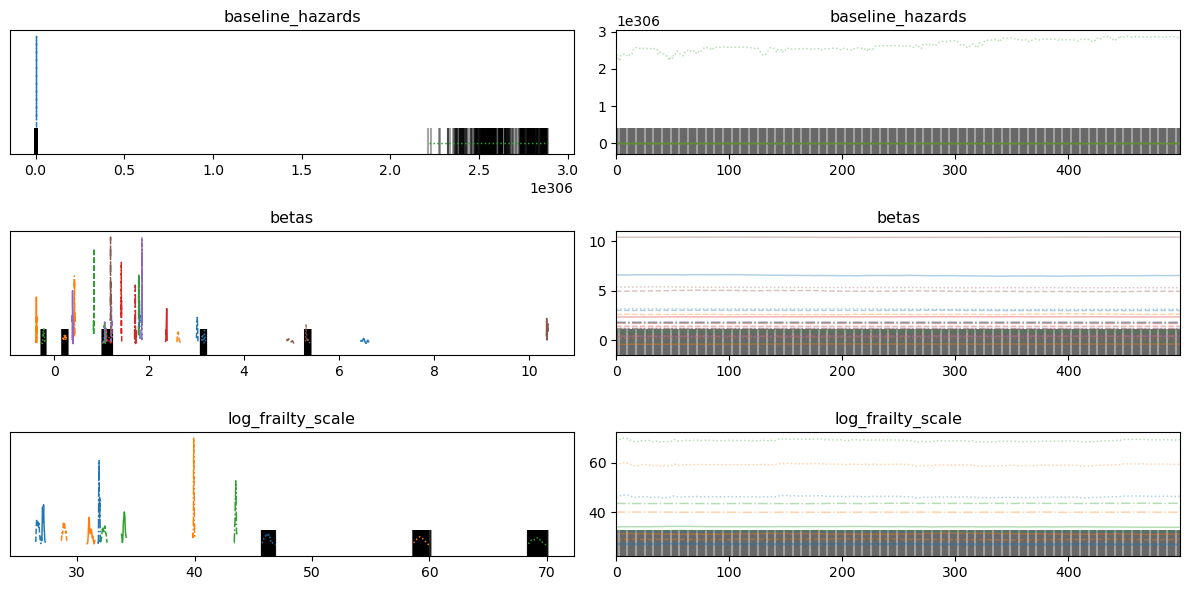

In [48]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazards", "betas", "log_frailty_scale"])
plt.tight_layout()
plt.show()

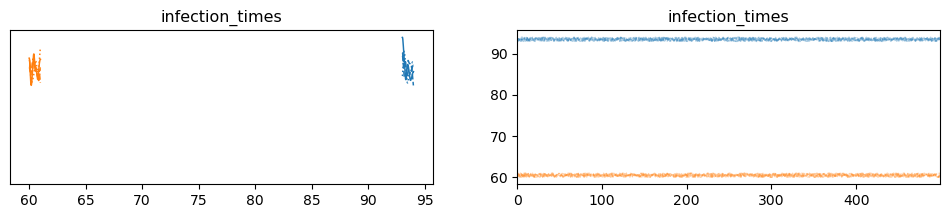

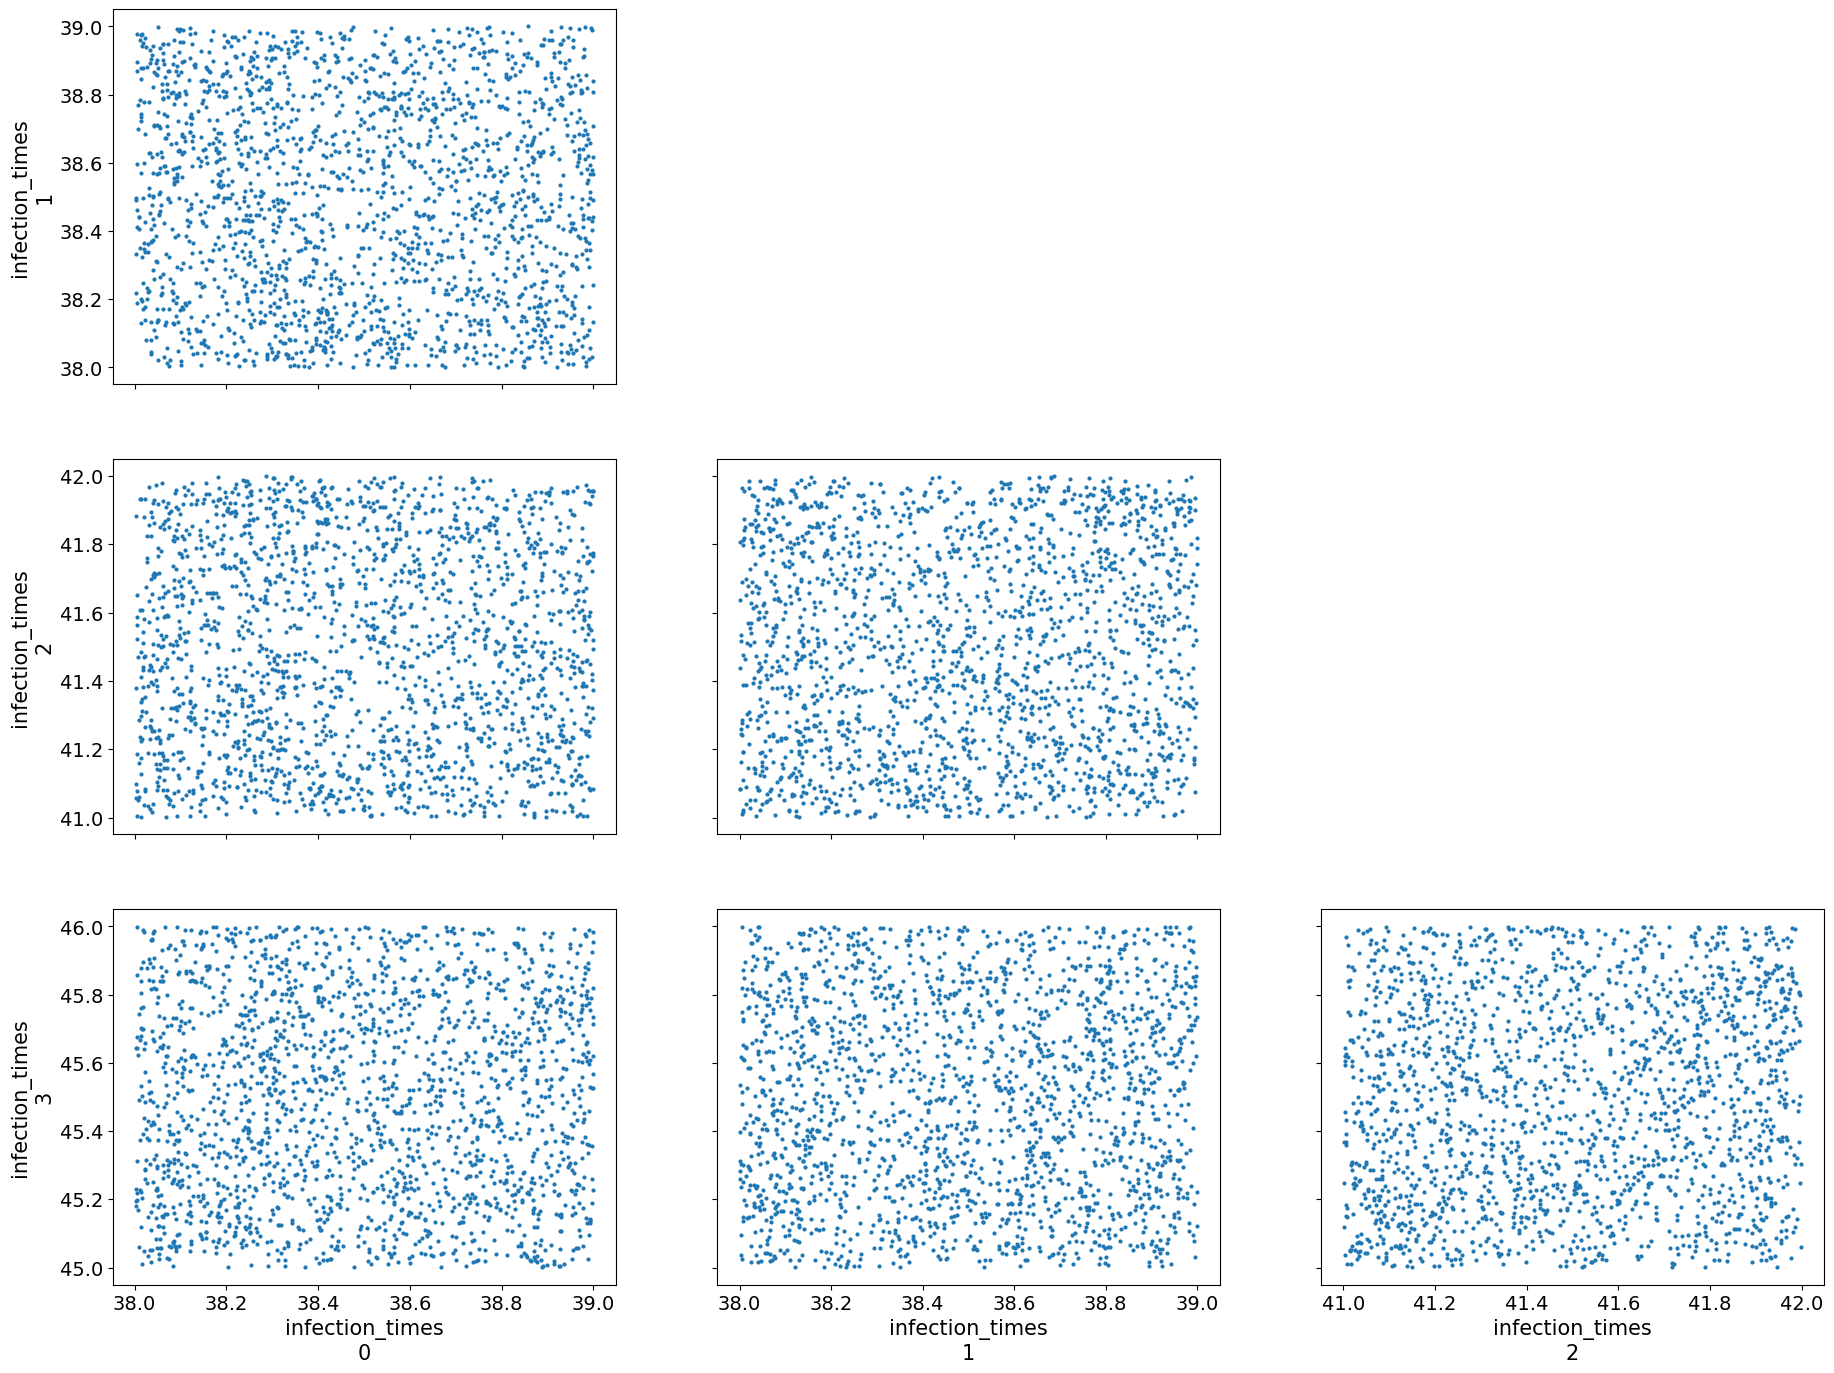

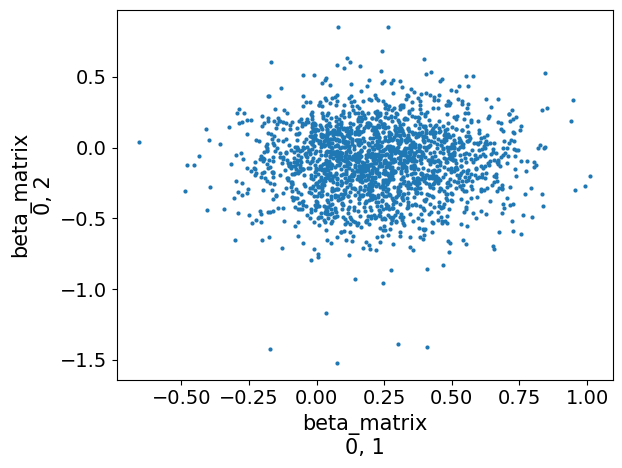

In [61]:
#more diagnostics
az.plot_trace(idata, var_names = "infection_times", coords= {"infection_times_dim_0": [10,11]})
plt.show()
az.plot_pair(
    idata,
    var_names=["infection_times"],
    coords={"infection_times_dim_0": [0, 1, 2, 3]},
    kind="scatter"
)
plt.show()
az.plot_pair(
    idata,
    var_names=["beta_matrix"],
    coords={"beta_matrix_dim_0": [0], "beta_matrix_dim_1": [1, 2]},
    kind="scatter"
)
plt.show()


True baseline hazards: [0.1, 0.2, 0.30000000000000004]


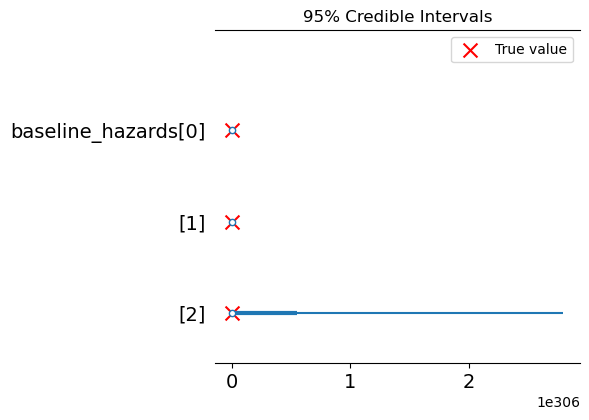

True beta coefficients: [[-0.         -0.52516981 -0.        ]
 [-0.         -0.          0.        ]
 [ 0.         -0.         -0.        ]]


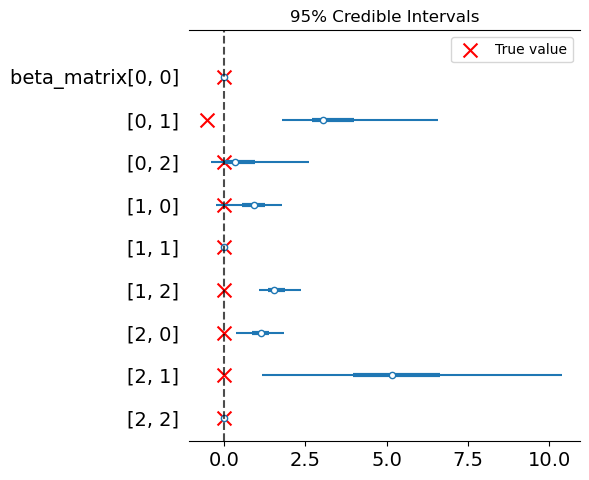

In [52]:
print(f"True baseline hazards: {baseline_hazards}")
axes = az.plot_forest(idata, var_names=["baseline_hazards"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
yticks = ax.get_yticks()
for i, val in enumerate(baseline_hazards[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if len(baseline_hazards) > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {beta_mat}")
axes = az.plot_forest(idata, var_names=["beta_matrix"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
yticks = ax.get_yticks()
for i, val in enumerate(beta_mat.flatten()[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if beta_mat.size > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

In [75]:
idata = az.from_cmdstanpy(posterior=fit)
# Now you can calculate WAIC and LOO
waic = az.waic(idata)
loo = az.loo(idata)

print(waic)
print(loo)

Computed from 2000 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -14251.67   119.40
p_waic       37.12        -
Computed from 2000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -14251.69   119.40
p_loo       37.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

